# **DSCI 100 Group Project Final: Predicting Usage of a Video Game Research Server**

- Group: project-009-26
- Members: Sua Kim, Jonathan Leung, Manny Vafaee, Jiaqi Zhuang

## **Introduction**

Datasets about video game use were collected from a Minecraft server set up by a CS group at UBC. The research group collected data on players' actions on the server, including gameplay, speech, and keystrokes <sup>[1]</sup>. Using the dataset collected, we aim to identify the characteristics of players who are most likely to contribute significant amounts of data, thereby defining the target for our recruitment. Specifically, we formulated the question to address the goal of our project:  **Can a player's age and experience level predict whether a player will become a high data contributor (measured by played_hours)?** 
Additionally, `players.csv` will be primarily used as we are focusing on player background information, rather than in-game session data.

### **Data Description**
To answer the question, we identify and fully describe the dataset `Players_csv` :

* 7 columns and 197 rows  
* Average value of hours played: 5.85  
* Average value of age: 21.14

### **Variable Description**
1. `experience`, “chr” type variable with five categories that represent the player’s experience level of Minecraft as `Pro`,`Veteran`,`Amateur`.`Regular`and`Beginner`
2. `subscribe`, “lgl” type variable with binary responses `True`and`False`, represents whether a player has subscribed to the game-related newsletter.
3. `hashedEmail`, “chr” type variable that represents player’s encrypted email
4. `played_hours`, “dbl” type variable that represents hours played
5. `name`, “chr” type variable that represents player’s name
6. `gender`, “chr” type variable that represents player’s gender with seven categories including `Male`,`Female`,`Non-binary`.`Prefer not to say`,`Agender`,`Two-Spirited`and`Other`
7. `Age`, “dbl” type variable that represents player’s age

## **Methods & Results**

### **Methodology**

To answer the question "What kinds of players are most likely to contribute to a large amount of data?", we will use a classification approach. To address the specific question, "Can a player's age and experience level predict whether a player will become a high data contributor (measured by `played_hours`)?", the continuous variable `played_hours` can be transformed into a binary variable type, `contributor_type`, labeling players as "high" or "low" contributors based on whether their playtime is in the top 25% of played hours. The `sessions.csv` file will be disregarded as our research questions focuses on player background rather than in-game session data. From the `players.csv` file, we will focus on `Age`, `experience`, and `played_hours`.

A K-Nearest Neighbours (K-NN) classification model will be used. This method will predict whether a player is a high or low contributor based on their age and experience level.

1. Prepare the data: Wrangle to create a binary response variable `contributor_type` (High if within top 25% of total hours played, low otherwise).Encode the categorical variable experience as an ordered factor and standardize `Age` so that both predictors contribute equally to the distance metric.
3. Split the data: 70% will be used for training, 30% will be used for testing.
4. Tune for k: Use t-fold cross-validation, train K-NN models, and select optimal number of neighbors.
5. Evaluate model performance on testing data using accuracy, precision, recall, and confusion matrix.

The model assumes that predictors are scaled, sufficient data, and that age and hours are not strongly correlated.


### **Loading, Reading, Summary of Data**

In [2]:
library(tidyverse)
library(tidymodels)
library(readr)
library(dplyr)
library(ggplot2)

options(repr.matrix.max.rows = 8)
options(repr.plot.height = 6, repr.plot.width = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
# Loading the data
# players will be the only dataset we examine to fulfill the research question
players <- read_csv("https://raw.githubusercontent.com/suakim550/DSCI100-Final-Group-Project/refs/heads/main/players.csv")
players
sessions <- read_csv("https://raw.githubusercontent.com/suakim550/DSCI100-Final-Group-Project/refs/heads/main/sessions.csv")
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
⋮,⋮,⋮,⋮,⋮
7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,01/07/2024 04:08,01/07/2024 04:19,1.71981e+12,1.71981e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [4]:
# Summary of loaded dataset
summary(players)
summary(sessions)

  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

 hashedEmail         start_time          end_time         original_start_time
 Length:1535        Length:1535        Length:1535        Min.   :1.712e+12  
 Class :character   Class :character   Class :character   1st Qu.:1.716e+12  
 Mode  :character   Mode  :character   Mode  :character   Median :1.719e+12  
                                                          Mean   :1.719e+12  
                                                          3rd Qu.:1.722e+12  
                                                          Max.   :1.727e+12  
                                                                             
 original_end_time  
 Min.   :1.712e+12  
 1st Qu.:1.716e+12  
 Median :1.719e+12  
 Mean   :1.719e+12  
 3rd Qu.:1.722e+12  
 Max.   :1.727e+12  
 NA's   :2          

In [4]:
# Wrangled player dataset, converts experience as factor
players_wrangled_data <- players |> 
    select(experience, Age, played_hours) |>
    arrange(desc(played_hours))|> 
    mutate(experience = as_factor(experience))

players_wrangled_data

experience,Age,played_hours
<fct>,<dbl>,<dbl>
Regular,17,223.1
Regular,20,218.1
Regular,19,178.2
Amateur,16,150.0
⋮,⋮,⋮
Amateur,17,0
Amateur,20,0
Amateur,17,0
Amateur,57,0


### **Data Visualization**

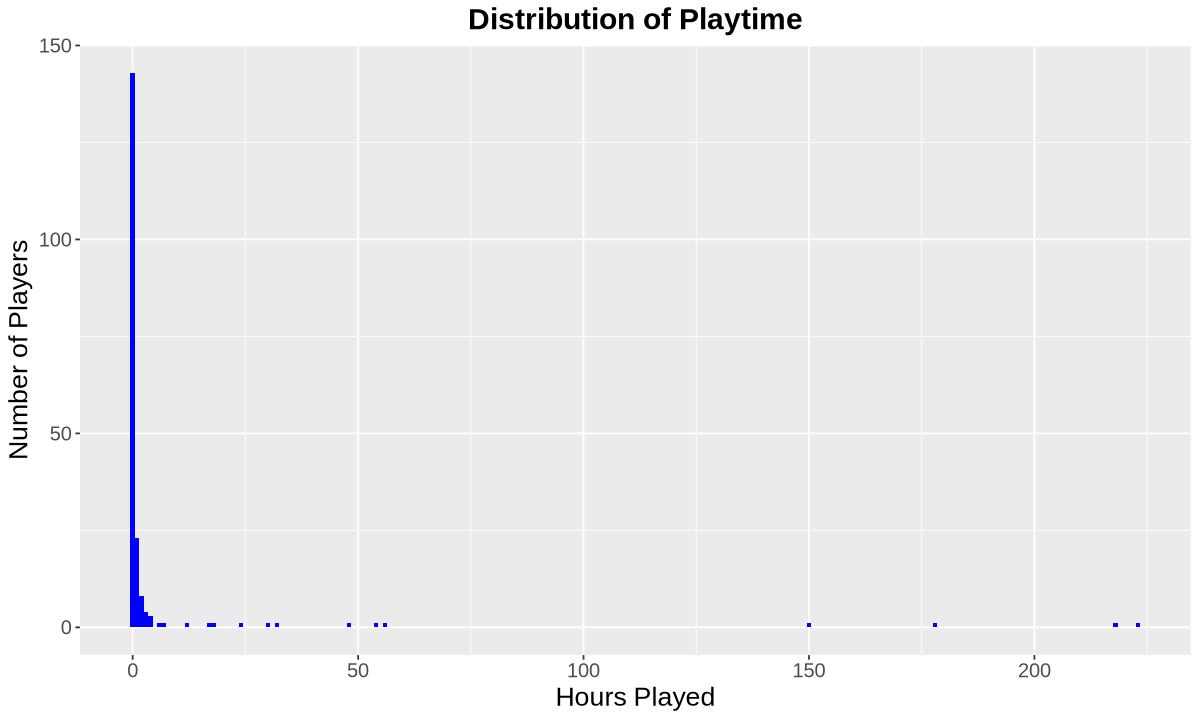

In [5]:
options(repr.plot.height = 6, repr.plot.width = 10)
fig_1 <- ggplot(players_wrangled_data, aes(x = played_hours)) +
    geom_histogram(binwidth = 1, fill = "blue") +
    labs(title = "Distribution of Playtime",
        x = "Hours Played",
        y = "Number of Players") +
    theme(plot.title = element_text(size = 18, face="bold", hjust = 0.5), axis.title = element_text(size = 16), axis.text = element_text(size = 12))

fig_1

**Figure 1.** This distribution shows the playtime data is very heavily right-skewed, suggesting that a small group of players are contributing to the "high contributors" category. Few players have much higher playtime (~200+ hours long). This data indicates that the majority of players engaged briefly, suggesting low sustained engagement or casual players. Additionally, this graph addresses the mean playtime being higher than the median, given the skew. 

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


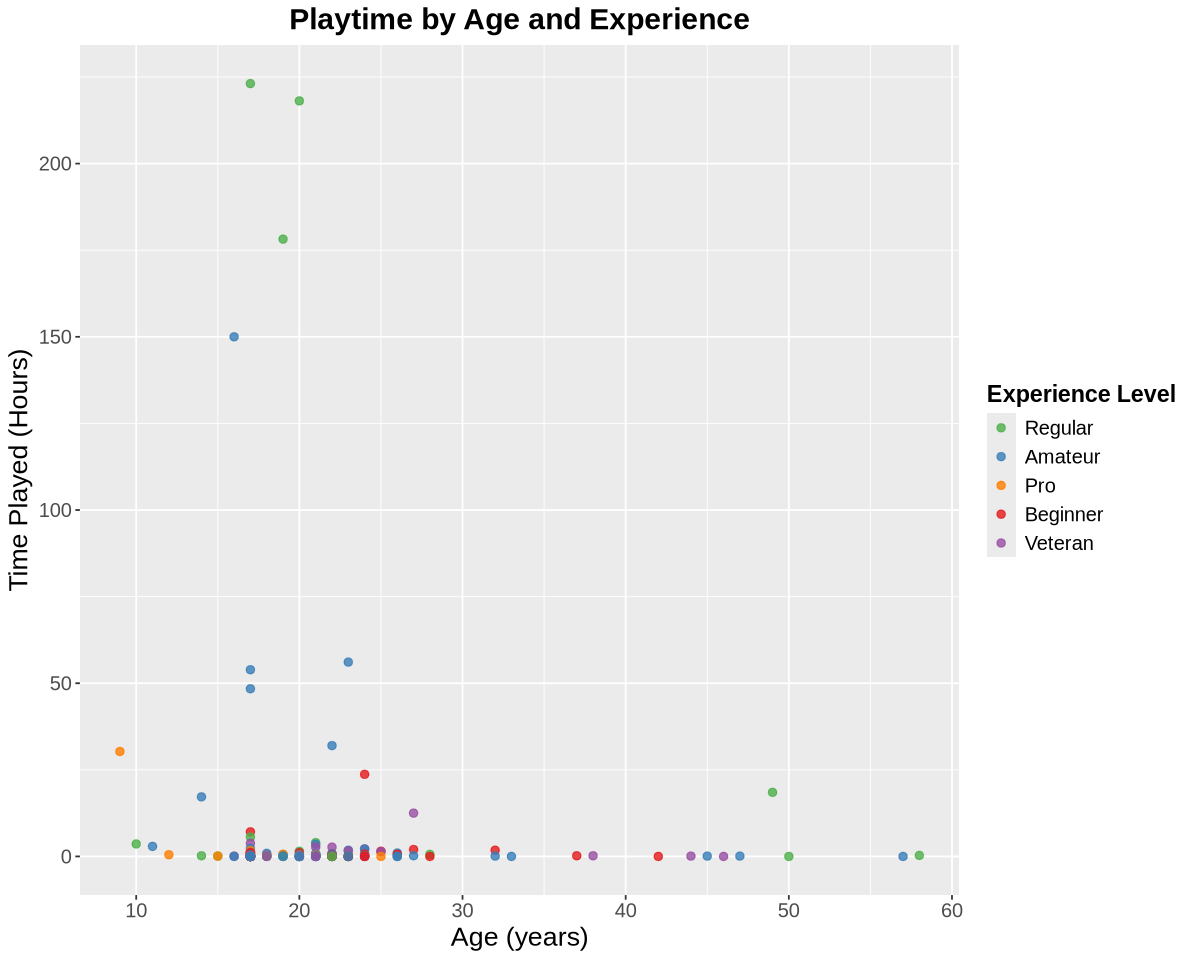

In [6]:
options(repr.plot.height = 8, repr.plot.width = 10)

fig_2 <- ggplot(players_wrangled_data, aes(x = Age, y = played_hours, color = experience)) +
    geom_point(size = 2, alpha = 0.8) +
    labs(title = "Playtime by Age and Experience",
        x = "Age (years)",
        y = "Time Played (Hours)",
        color = "Experience Level") +
    scale_color_manual(
        values = c(
        "Beginner" = "#e41a1c",  
        "Amateur"  = "#377eb8", 
        "Regular"  = "#4daf4a",  
        "Pro"      = "#ff7f00",  
        "Veteran"  = "#984ea3"   
        )) +
    theme(plot.title = element_text(size = 18, face="bold", hjust = 0.5), 
          axis.title = element_text(size = 16), 
          axis.text = element_text(size = 12), 
          legend.title = element_text(size = 14, face = "bold"), 
          legend.text = element_text(size = 12))

fig_2

**Figure 2.** These figures reveal interactions between age and experience. For instance, it appears that amateur and regular players tend to have higher playtimes, while beginners and veterans have lower playtimes. Additionally, the log transformation of the y-axis reduces the influence of extreme outliers and makes the data more balanced for easier visualization. This data confirms that younger players, tend to play more (particularly regular, amateur, or pro experience level), while older players show lower, more uniform playtime across experience groups. 

In [7]:
playtime_summary <- players_wrangled_data |>
    group_by(experience) |>
    summarise(
        mean_playtime = mean(played_hours, na.rm = TRUE),
        median_playtime = median(played_hours, na.rm = TRUE),
        sd_playtime = sd(played_hours, na.rm = TRUE),
        min_playtime = min(played_hours, na.rm = TRUE),
        max_playtime = max(played_hours, na.rm = TRUE),
        count = n()
    ) |>
    arrange(experience)

playtime_summary

experience,mean_playtime,median_playtime,sd_playtime,min_playtime,max_playtime,count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Regular,18.2083333,0.1,57.957346,0,223.1,36
Amateur,6.0174603,0.1,21.987214,0,150.0,63
Pro,2.6000000,0.3,7.988838,0,30.3,14
Beginner,1.2485714,0.1,4.105547,0,23.7,35
Veteran,0.6479167,0.1,1.937424,0,12.5,48


##### **Table 1. Summary of Playtime by Experience Level**
| experience | mean_playtime | median_playtime | sd_playtime | min_playtime | max_playtime | count |
|------------|---------------|----------------|-------------|--------------|--------------|-------|
| Regular    | 18.21         | 0.10           | 57.96       | 0.00         | 223.10       | 36    |
| Amateur    | 6.02          | 0.10           | 21.99       | 0.00         | 150.00       | 63    |
| Pro        | 2.60          | 0.30           | 7.99        | 0.00         | 30.30        | 14    |
| Beginner   | 1.25          | 0.10           | 4.11        | 0.00         | 23.70        | 35    |
| Veteran    | 0.65          | 0.10           | 1.94        | 0.00         | 12.50        | 48    |

**Table 1.** The median playtime is about the same for all categories. However, the mean playtime differs for each category. Regular players have the highest mean time (18.21 hours), and the widest spread of values. Pro, Beginner, and Veteran players all have relatively low averages, implying that most players in these categories contribute less data ovearll. This reinforces that a small subset of regular and amateur players are responsible for most of the total gameplay data. 

### **Data Analysis**

In [8]:
# Prepare the data; Define high contributor (High if within top 25% of total hours played, low otherwise).
players_wrangled_data_2 <- players_wrangled_data |> 
    mutate(high_contributor = if_else(played_hours >= quantile(played_hours, 0.75), "High", "Low")) |> 
    mutate(high_contributor = factor(high_contributor))

players_wrangled_data_2

experience,Age,played_hours,high_contributor
<fct>,<dbl>,<dbl>,<fct>
Regular,17,223.1,High
Regular,20,218.1,High
Regular,19,178.2,High
Amateur,16,150.0,High
⋮,⋮,⋮,⋮
Amateur,17,0,Low
Amateur,20,0,Low
Amateur,17,0,Low
Amateur,57,0,Low


In [9]:
# Split and train data; Convert all categorical predictors to dummy; Remove predictors with zero variance; Normalize all predictors
set.seed(123)

data_split <- initial_split(players_wrangled_data_2, prop = 0.7, strata = high_contributor)
train_data <- training(data_split)
test_data <- testing(data_split) |>
    drop_na()

players_recipe <- recipe(high_contributor ~ Age + experience, data = train_data) |>
    step_dummy(all_nominal_predictors()) |>
    step_novel(all_nominal_predictors()) |>
    step_zv(all_predictors()) |>
    step_normalize(all_numeric_predictors())

train_data <- players_wrangled_data_2 |>
    select(Age, experience, played_hours, high_contributor) |>
    drop_na()

In [10]:
# Tune for k
set.seed(123)

folds <- vfold_cv(train_data, v=5, strata = high_contributor)
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_tune <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = folds, grid = k_vals) 

accuracies <- knn_tune |> 
    collect_metrics() |>
    filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.3917341,5,0.03420445,Preprocessor1_Model01
2,accuracy,binary,0.3860796,5,0.02764699,Preprocessor1_Model02
3,accuracy,binary,0.4429015,5,0.03851332,Preprocessor1_Model03
4,accuracy,binary,0.4426518,5,0.03334597,Preprocessor1_Model04
⋮,⋮,⋮,⋮,⋮,⋮,⋮
7,accuracy,binary,0.5156478,5,0.06780131,Preprocessor1_Model07
8,accuracy,binary,0.5156478,5,0.06223994,Preprocessor1_Model08
9,accuracy,binary,0.6395951,5,0.06383749,Preprocessor1_Model09
10,accuracy,binary,0.6289339,5,0.06990666,Preprocessor1_Model10


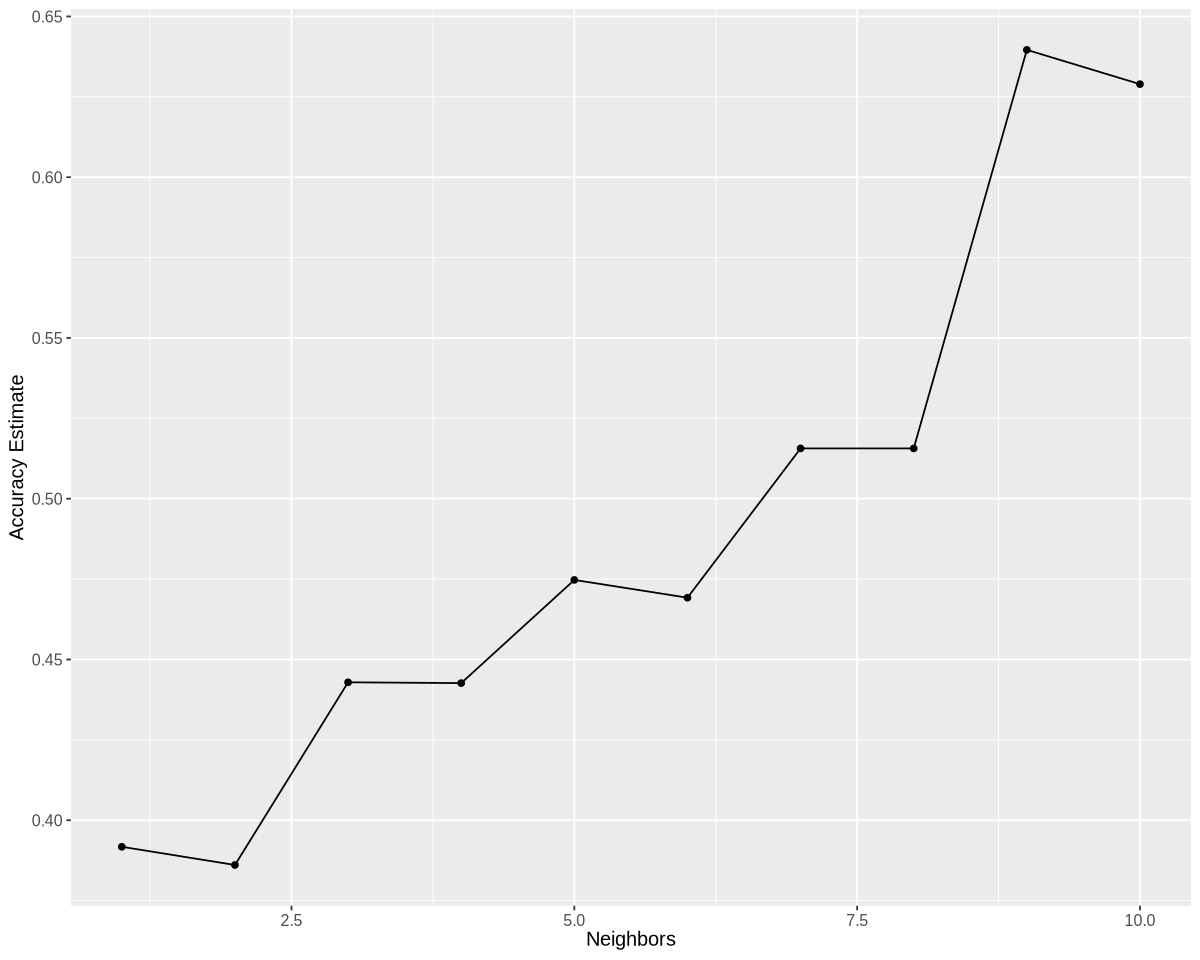

In [11]:
# Generate accuracy estimation plot to determine optimal k
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))

accuracy_vs_k

**Figure 3:** The graph above shows the accuracy estimation vs number of neighbors used in the K-NN algorithm, according to a 5-fold cross validation of the training data. Based on the graph, a 9-neighbor model was selected, as it yielded the highest accuracy results. 

In [12]:
# Select optimal k from graph above
optimal_k <- accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
optimal_k

[1] 9

In [13]:
# K-NN model
knn_spec_model <- nearest_neighbor(weight_func = "rectangular", 
                                   neighbors = optimal_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_model) |>
    fit(data = train_data)

players_predictions <- predict(knn_results, test_data) |>
    bind_cols(test_data)

players_predictions

.pred_class,experience,Age,played_hours,high_contributor
<fct>,<fct>,<dbl>,<dbl>,<fct>
Low,Regular,17,223.1,High
Low,Regular,20,218.1,High
Low,Amateur,17,53.9,High
Low,Regular,21,4.0,High
⋮,⋮,⋮,⋮,⋮
Low,Veteran,17,0,Low
Low,Regular,22,0,Low
Low,Veteran,20,0,Low
Low,Beginner,17,0,Low


In [14]:
# Accuracy
players_predictions |>
    metrics(truth = high_contributor, estimate = .pred_class) |>
    filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7457627


In [15]:
# Precision
players_predictions |> pull(high_contributor) |> levels()

players_predictions |>
    precision(truth = high_contributor, estimate = .pred_class, event_level = "first")

[1] "High" "Low"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.6666667


In [16]:
# Recall
players_predictions  |>
    recall(truth = high_contributor, estimate = .pred_class, event_level = "first")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.125


#### **Table 2: Summary of Accuracy, Precision, and Recall**
| Metric | Value | 
|----------|----------|
| Accuracy  | 74.58%  |
| Precision | 66.67%  |
| Recall    | 12.5%  |

**Table 2:** The table above shows the Accuracy, Precision, and Recall of the model

In [17]:
# Confusion matrix
confusion <- players_predictions  |>
             conf_mat(truth = high_contributor, estimate = .pred_class)
confusion

          Truth
Prediction High Low
      High    2   1
      Low    14  42

#### **Table 3: Confusion Matrix**
| Prediction ↓ / Truth → | High | Low |
|--------------------|------|-----|
| High               | 2    | 1   |
| Low                | 14   | 42  |

**Table 3:** The table above shows the confusion matrix generated from the model. The columns show the truth based on `contributor_type` factor, while the rows show the prediction by the model.

## **Discussion**

### **Visuals**
According to Figures 1 and 2, the trend between age, experience, and play time was not evident. Additionally, we can see that there are many more players with lower playtime. Therefore, using a K-NN model would have been more effective than linear regression. The model’s accuracy also suggests the presence of patterns; however, the combination of variables was not an ideal predictor of `contributor_type`. 

### **Predicting “High” contributors**
The confusion matrix shows that the model barely predicts “High” contributors. Of those who were actually high (True Positives), the model predicts that two-thirds of the time are high, but this is misleading, as it barely predicts “High” contributors. There are 59 samples in total, but only three samples were listed as “High”.

Recall: the proportion of all actual positive cases that were correctly identified by the model.
The recall is low here at 12.5%, as the model showed poor predictive performance for “High” contributors: only 2 of the 16 high contributors were predicted. 
We were only able to predict 2 of the 16, and failed to predict the other 14 high contributors.

### **Predicting “Low” contributors**
The confusion matrix shows that the model indicates that this model mainly predicts the “Low” group instead of the “High” group. Of those who are actually Low (True Negative), 42 accurate “Low” predictions were actually “Low” (True Negative) and only one Low was mispredicted as “High” (False Positive). This also means that the prediction of the “Low” contributors is mostly accurate, and this model confidently predicts the “Low” contributors. 

### **Therefore, this model is poor at predicting high contributors.**
This result is unexpected, as we aim to find the “High” contributors. Instead, this model is suitable for finding the low contributors, as most “Low” correctly identifies most of the “Low” contributors. Since this model is not effective for predicting the “High” contributors, it is not helpful to address our main question: **“Can a player's age and experience level predict whether a player will become a high data contributor (measured by played_hours)?”** Even with “High” contributors, the model consistently misinterprets them, as evidenced by the low recall. However, instead of predicting “High” contributors, we can predict “Low” contributors, as it mostly correctly identifies the “Low” contributors, and the model is confident in determining the “Low” contributors. 

### **Limitations and Suggestions for Improvement**
The model created relied mainly on demographic variables (such as age and experience) from the `players.csv` dataset, and lacked behavioral features. Incorporating session based data from the `sessions.csv` dataset could assist in improving accuracy, especially recall (the priority to avoid missing high data contributors). Additionally, with only 196 observations and an imbalanced target (many players with low play time, hence a lot of low contributor data), the model struggled to generalize. A larger dataset with more contributors would yield more reliable predicitions. Finally, missing or unclear values regarding playtime likely reduced model performance. Improving data collection and cleaning processes would strengthen future models.

### **Future Questions**
Based on the model's prediction (Table 3), it is evident that there are more low contributors compared to high contributors. This low contributor information can help address a similar question: What are the characteristics of players who are least likely to contribute to the data, thereby excluding them from the target for our recruitment. 

### **Conclusion**
To conclude, because the model cannot reliably predict high contributors, it is ineffective at identifying the characteristics of players most likely to contribute significant amounts of data. However, we can still gain valuable insights by identifying the characteristics of the “Low” contributors and excluding them from our recruitment target. By eliminating the low-contributor samples, we could focus on potential high contributors and evaluate the relationship between the selected variables (age and experience level) and the modified data (potential high contributors). 


## **References**

[1] Pacific Laboratory of Artificial Intelligence. (2024, March 19). Plaicraft. PLAICraft. https://plaicraft.ai/